# HA1 - Cats and dogs

<img src="http://lghttp.32478.nexcesscdn.net/80E972/organiclifestylemagazine/wp-content/uploads/2015/10/Cats-and-Dogs.jpg" alt="Cats and dogs" style="width: 5000px;"/>

For this home assignment, we'll use the Kaggle dataset for the [Dogs vs. Cats competition](https://www.kaggle.com/c/dogs-vs-cats). It comprises of 25k colored images of dogs and cats. Our goal with this dataset will be to create a classifier that can tell us if the input image is of a cat or a dog.

Requirements:
- Whenever we ask you to plot anything, be sure to add a title and label the axes. If you're plotting more than one curve in the same plot, also add a legend.
- When we ask you to train an architecture, train it for a reasonable number of epochs. "Reasonable" here means you should be fairly confident that training for a higher number of epochs wouldn't impact your conclusions regarding the model's performance.

Tips:
- If you get errors saying you've exhausted the GPU resources, well, then you exhausted the GPU resources ;). However, sometimes that's because TensorFlow didn't release a part of the GPU's memory. If you think your CNN should fit in your memory during training, try restarting the kernel and directly training only that architecture.
- Every group has enough credits on google cloud to complete this assignment. However, this statement assumes you'll use your resources judiciously (e.g. always try the code first in your machine and make sure everything works properly before starting your instances) and **won't forget to stop your instance after using it,**  otherwise you might run out of credits.
- Before starting, take a look at the images we'll be using. This is a hard task, don't get discouraged if your first models perform poorly (several participants in the original competition didn't achieve an accuracy higher than 60%).

---
## 0. Imports

In the following cell, add all the imports you'll use in this assignment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.layers.convolutional import Conv2D
from keras.layers.core import Flatten
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.metrics import categorical_crossentropy

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

import pickle
import os

import matplotlib.pyplot as plt

Using TensorFlow backend.


---
## 1. Loading the data and preprocessing

The first step is to head to the [Kaggle website for the cats and dogs competition](https://www.kaggle.com/c/dogs-vs-cats) and download the data from there. You should download both the `train.zip` and `test.zip` files. The split ratio between training and validation has not been made, you'll need to do it yourself. The `test.zip` file contains unlabeled data, so that participants in the contest are not able to train on this set.

As mentioned in CL3, for this assignment you should use [data generators](https://keras.io/preprocessing/image/) to load the images to your CPU/GPU memory. Because of this, your folder structure for the data should conform to the folder structure expected by the data generators (i.e. the samples should be separated into one folder for each class). Furthermore, we ask you to first start with a smaller subset of the data (1/5 of the number of samples), in order to test different models faster.

This means that you should create a folder structure that resembles the following (obviously, the folder names are up to you):


         small_train             small_val                train                   val
              |                      |                      |                      |
              |                      |                      |                      |
        -------------          -------------          -------------          -------------
        |           |          |           |          |           |          |           |
        |           |          |           |          |           |          |           |
      Cats        Dogs       Cats        Dogs       Cats        Dogs       Cats        Dogs

The `small_train` and `small_val` folders have the training and validation samples for your smaller subset of the data, while the `train` and `val` folders contain all the samples you extracted from Kaggle's `train.zip`. We provide you a notebook that shows how to achieve this, starting from the original `train` folder extracted from `train.zip`. If you do use that notebook, we encourage you to understand how each step is being done, so you can generalize this knowledge to new datasets you'll encounter.

Although we specifically guide you to use 1/5 of the data in the smaller dataset, you should decide how to split the validation data. Please specify your splits in the following cells.

** ------------------  Smaller subset ------------------ **

** % Samples in the training set:** (1750 cats; 1750 dogs)

** % Samples in the validation set:** (750 cats; 750 dogs)

** ------------------  Entire dataset ------------------ **

** % Samples in the training set:** (11250 cats; 11250 dogs)

** % Samples in the validation set:** (1250 cats; 1250 dogs)

---
Once you have the expected folder structure, create two data generators for automatically generating batches from the images in your smaller subset of data. Don't use any [data augmentation](https://cartesianfaith.com/2016/10/06/what-you-need-to-know-about-data-augmentation-for-machine-learning/), but feel free to preprocess the data as you see fit. After instantiating them, run the `flow_from_directory` method with the desired arguments.

Hints:
- The specified `batch_size` should be chosen so that your don't run out of memory.
- When feeding the images to your CNN, you'll probably want all of them to have the same spatial size, even though the .jpeg files differ in this. If so, take a look at the argument `target_size` for the `flow_from_directory` method of data generators.
- Resizing the images to a smaller size while loading them can be beneficial.

In [2]:
#setting paths to Data folders
train_path = 'small_train'
validation_path = 'small_val'
test_path = 'test1'

#Batch size
batch_s = 32

#picture resolution/size
img_hight = 224
img_width = 224
img_size = (img_hight, img_width)

train_batches = keras.preprocessing.image.ImageDataGenerator().flow_from_directory(train_path,
                                                                                   target_size = img_size,
                                                                                   classes=['cats','dogs'], 
                                                                                   batch_size = batch_s)

validation_batches = keras.preprocessing.image.ImageDataGenerator().flow_from_directory(validation_path,
                                                                                        target_size = img_size,
                                                                                        classes=['cats','dogs'],
                                                                                        batch_size = batch_s)

test_batches = keras.preprocessing.image.ImageDataGenerator().flow_from_directory(test_path,
                                                                                  target_size = img_size,
                                                                                  batch_size=batch_s)

Found 3500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


---
## 2. Training

Create your first CNN architecture for this task. Start with something as simple as possible, that you're almost sure can get an accuracy better than 50% (we'll improve upon it later).

Tip:
- If Tensorflow is your backend, your `input_shape` is always `(img_width, img_height, 3)` (i.e. channels **last**)

In [3]:
#convolutional layers
conv_layer_1 = Conv2D(50,(3,3), activation='relu', input_shape = (224,224,3))
conv_layer_2 = Conv2D(50,(3,3), activation='relu')
conv_layer_3 = Conv2D(10,(3,3), activation='relu')

#maxpooling layers
maxpool_layer_1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)

#flattening layer
flatening_layer = Flatten()

#dense layers
dense_layer_1 = Dense(20, activation='relu')
dense_layer_2 = Dense(10, activation='relu')
dense_layer_3 = Dense(2, activation='softmax')

#model architecture initialization
model_layer_list = [conv_layer_1, conv_layer_2, conv_layer_3,
                    maxpool_layer_1, 
                    flatening_layer,
                    dense_layer_1, dense_layer_2, dense_layer_3]

model = Sequential(model_layer_list)

#model optimizer initialisation
model.compile(Adam(lr=0.000005),loss='categorical_crossentropy',metrics=['accuracy'])

#model architecture overview
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 50)      1400      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 50)      22550     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 218, 218, 10)      4510      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 109, 109, 10)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 118810)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2376220   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
__________

Train your model using the `fit_generator` method and the two data generators you created earlier. Train for a reasonable amount of epochs, so as to get a good sense of how well this architecture performs.

In [53]:
# training model
history_graph = model.fit_generator(train_batches, steps_per_epoch = 20,
                    validation_data = validation_batches,
                    validation_steps = 10, epochs=200, verbose=2)

# saving history data to file
try:
    history =history.history
except AttributeError:
    print('History is already an dictionary')
    
path = "C:\\Users\\sandr\\Documents\\Skola\\Deep Neural Networks\\Deep-Neural-Network\\Home Assignments\\HA1\\Training history\\Simple\\"
            
list_files = next(os.walk(path))[2] 
name = 'History_graph_simle ' +  str(len(list_files))
with open(path + name + '.pkl', 'wb') as f:
        pickle.dump(history, f)
f.close()

#saving models to file
model_path = r'C:\Users\sandr\Documents\Skola\Deep Neural Networks\Deep-Neural-Network\Home Assignments\HA1\models\Simple' 
list_files = next(os.walk(path_model))[2] 
model_name = '\Keras model simple CNN ' +  str(len(list_files))
model.save(model_path + model_name)

History is already an dictionary


Create one figure with two axes. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.

Hint:
- The `fit_generator` method returns a `history` object.

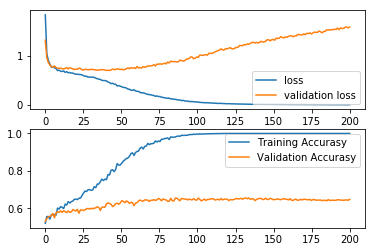

In [16]:
path = r'C:\Users\sandr\Documents\Skola\Deep Neural Networks\Deep-Neural-Network\Home Assignments\HA1\Training history\Simple'
list_files = os.listdir(path)
name = '\\History_graph_simple' +  str(len(list_files))   
with open(path + name + '.pkl', 'rb') as f:
        history_graph = pickle.load(f)
f.close()
x = np.linspace(0,len(history_graph['loss']),len(history_graph['loss']))

plt.subplot(2,1,1)
plt.plot(x, history_graph['loss'])
plt.plot(x, history_graph['val_loss'])
plt.legend(['Training loss','Validation loss'])

plt.subplot(2,1,2)
plt.plot(x, history_graph['acc'])
plt.plot(x, history_graph['val_acc'])
plt.legend(['Training Accurasy','Validation Accurasy'])

plt.show()

Based on these, what would you suggest for improving your model? Why?

**Your answer**: (fill in here)

---
## 3. Improving your initial model

Improve your initial model according to you answer above. Write the new definition in the cell below and train it.

In [3]:
#convolutional layers
conv_layer_1 = Conv2D(50,(3,3), activation='relu', input_shape = (224,224,3))
conv_layer_2 = Conv2D(50,(3,3), activation='relu')
conv_layer_3 = Conv2D(50,(3,3), activation='relu')
conv_layer_2_1 = Conv2D(200,(3,3), activation='relu')
conv_layer_2_2 = Conv2D(200,(3,3), activation='relu')
conv_layer_2_3 = Conv2D(300,(3,3), activation='relu')
conv_layer_3_1 = Conv2D(300,(3,3), activation='relu')
conv_layer_3_2 = Conv2D(20,(3,3), activation='relu')

#maxpooling layers
maxpool_layer_1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)
maxpool_layer_2 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)
maxpool_layer_3 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)
maxpool_layer_4 = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid', data_format=None)

#dropoutlayer
dropout_layer_1 = keras.layers.Dropout(0.1, noise_shape=None, seed=None)
dropout_layer_2 = keras.layers.Dropout(0.3, noise_shape=None, seed=None)
dropout_layer_3 = keras.layers.Dropout(0.5, noise_shape=None, seed=None)

#flattening layer
flatening_layer = Flatten()

#dense layers
dense_layer_1 = Dense(512, activation='relu')
dense_layer_2 = Dense(10, activation='relu')
dense_layer_3 = Dense(2, activation='softmax')

#model architecture initialization
model_layer_list = [conv_layer_1, conv_layer_2, conv_layer_3,
                    maxpool_layer_1, 
                    conv_layer_2_1, conv_layer_2_2, conv_layer_2_3,
                    maxpool_layer_2, dropout_layer_1,
                    conv_layer_3_1, conv_layer_3_2,
                    maxpool_layer_3, dropout_layer_2, flatening_layer,
                    dense_layer_1,
                    dropout_layer_3,
                    dense_layer_2, dense_layer_3]

improved_model = Sequential(model_layer_list)

#model optimizer initialisation
improved_model.compile(Adam(lr=0.00001),loss='categorical_crossentropy',metrics=['accuracy'])

#model architecture overview
improved_model.summary()

improved_history_graph = improved_model.fit_generator(train_batches, steps_per_epoch = 107,
                    validation_data = validation_batches,
                    validation_steps = 50, epochs=200, verbose=2)

# saving history data to file
try:
    history =improved_history_graph.history
except AttributeError:
    print('History is already an dictionary')
    
path = r"C:\Users\sandr\Documents\Skola\Deep Neural Networks\Deep-Neural-Network\Home Assignments\HA1\Training history\Improved"
            
list_files = next(os.walk(path))[2] 
name = '\History_graph_improved ' +  str(len(list_files)+1)
with open(path + name + '.pkl', 'wb') as f:
        pickle.dump(history, f)
f.close()

#saving models to file
model_path = r'C:\Users\sandr\Documents\Skola\Deep Neural Networks\Deep-Neural-Network\Home Assignments\HA1\models\Improved' 
list_files = next(os.walk(model_path))[2] 
model_name = '\Keras model simple CNN ' +  str(len(list_files)+1)
improved_model.save(model_path + model_name)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 50)      1400      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 50)      22550     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 218, 218, 50)      22550     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 109, 109, 50)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 107, 107, 200)     90200     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 105, 105, 200)     360200    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 103, 103, 300)     540300    
__________

Epoch 65/200
 - 39s - loss: 0.1712 - acc: 0.9334 - val_loss: 0.6599 - val_acc: 0.7427
Epoch 66/200
 - 39s - loss: 0.1657 - acc: 0.9382 - val_loss: 0.6497 - val_acc: 0.7433
Epoch 67/200
 - 39s - loss: 0.1653 - acc: 0.9296 - val_loss: 0.6526 - val_acc: 0.7460
Epoch 68/200
 - 39s - loss: 0.1507 - acc: 0.9436 - val_loss: 0.6984 - val_acc: 0.7420
Epoch 69/200
 - 39s - loss: 0.1465 - acc: 0.9439 - val_loss: 0.7174 - val_acc: 0.7420
Epoch 70/200
 - 39s - loss: 0.1399 - acc: 0.9483 - val_loss: 0.6816 - val_acc: 0.7473
Epoch 71/200
 - 39s - loss: 0.1390 - acc: 0.9474 - val_loss: 0.6750 - val_acc: 0.7407
Epoch 72/200
 - 39s - loss: 0.1449 - acc: 0.9427 - val_loss: 0.6889 - val_acc: 0.7473
Epoch 73/200
 - 39s - loss: 0.1217 - acc: 0.9503 - val_loss: 0.7034 - val_acc: 0.7447
Epoch 74/200
 - 39s - loss: 0.1313 - acc: 0.9466 - val_loss: 0.6894 - val_acc: 0.7427
Epoch 75/200
 - 39s - loss: 0.1269 - acc: 0.9452 - val_loss: 0.7074 - val_acc: 0.7493
Epoch 76/200
 - 39s - loss: 0.1193 - acc: 0.9519 - val

Epoch 160/200
 - 39s - loss: 0.0190 - acc: 0.9939 - val_loss: 1.0817 - val_acc: 0.7507
Epoch 161/200
 - 39s - loss: 0.0254 - acc: 0.9900 - val_loss: 1.1168 - val_acc: 0.7507
Epoch 162/200
 - 39s - loss: 0.0168 - acc: 0.9953 - val_loss: 1.1461 - val_acc: 0.7547
Epoch 163/200
 - 39s - loss: 0.0309 - acc: 0.9898 - val_loss: 1.1003 - val_acc: 0.7493
Epoch 164/200
 - 39s - loss: 0.0199 - acc: 0.9933 - val_loss: 1.0947 - val_acc: 0.7460
Epoch 165/200
 - 39s - loss: 0.0237 - acc: 0.9945 - val_loss: 1.0975 - val_acc: 0.7620
Epoch 166/200
 - 39s - loss: 0.0279 - acc: 0.9913 - val_loss: 1.1372 - val_acc: 0.7487
Epoch 167/200
 - 39s - loss: 0.0160 - acc: 0.9947 - val_loss: 1.1024 - val_acc: 0.7493
Epoch 168/200
 - 39s - loss: 0.0181 - acc: 0.9939 - val_loss: 1.1214 - val_acc: 0.7727
Epoch 169/200
 - 39s - loss: 0.0192 - acc: 0.9930 - val_loss: 1.0847 - val_acc: 0.7587
Epoch 170/200
 - 39s - loss: 0.0184 - acc: 0.9953 - val_loss: 1.1464 - val_acc: 0.7467
Epoch 171/200
 - 39s - loss: 0.0219 - acc: 

Plot the accuracy in the test and validation set, using the initial model and your newly improved one.

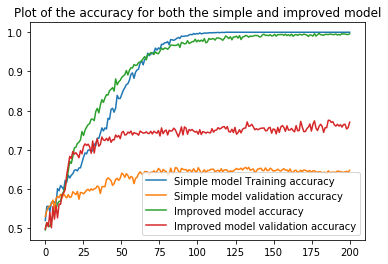

In [34]:
path_simple = r'C:\Users\sandr\Documents\Skola\Deep Neural Networks\Deep-Neural-Network\Home Assignments\HA1\Training history\Simple'
path_improved = r'C:\Users\sandr\Documents\Skola\Deep Neural Networks\Deep-Neural-Network\Home Assignments\HA1\Training history\Improved'
list_files_simple = os.listdir(path_simple)
list_files_improved = os.listdir(path_improved)
name_simple = '\History_graph_simple ' +  str(len(list_files_simple)) 
name_improved = '\History_graph_improved ' + str(len(list_files_improved))
with open(path_simple + name_simple + '.pkl', 'rb') as f:
        history_graph_simple = pickle.load(f)
f.close()
with open(path_improved + name_improved + '.pkl', 'rb') as f:
        history_graph_improved = pickle.load(f)
f.close()


x = np.linspace(0,len(history_graph_simple['loss']),len(history_graph_simple['loss']))

fig, ax = plt.subplots()
ax.plot(x, history_graph_simple['acc'], label = 'Simple model Training accuracy')
ax.plot(x, history_graph_simple['val_acc'], label = 'Simple model validation accuracy')
ax.plot(x, history_graph_improved['acc'], label = 'Improved model accuracy')
ax.plot(x, history_graph_improved['val_acc'], label = 'Improved model validation accuracy')
ax.legend()
ax.set_title('Plot of the accuracy for both the simple and improved model') 


plt.show()

Did your results improve? Explain why, or why not.

**Your answer**: (fill in here)

---
## 4. Obtaining the *best* model

Continue to improve your model architecture by comparing the value of the metrics you're interested in both the training and validation set. Try different ideas, and consider comparing them using tensorboard. When you're happy with one architecture, copy it in the cell below and train it here. Save the optimization history (i.e. the `history` object returned by the `fit_generator`). You'll use this later to compare your best model with the one using transfer learning.

**Note**: When trying different ideas, you'll end up with several different models. However, when submitting your solutions to ping-pong, the cell below must contain only the definition and training of *one* model. Remove all code related to the models that were not chosen.

In [ ]:
#convolutional layers
conv_layer_1 = Conv2D(70,(3,3), activation='relu', input_shape = (224,224,3))
conv_layer_2 = Conv2D(100,(3,3), activation='relu')
conv_layer_3 = Conv2D(100,(3,3), activation='relu')
conv_layer_2_1 = Conv2D(200,(3,3), activation='relu')
conv_layer_2_2 = Conv2D(200,(3,3), activation='relu')
conv_layer_2_3 = Conv2D(200,(3,3), activation='relu')
conv_layer_3_1 = Conv2D(300,(3,3), activation='relu')
conv_layer_3_2 = Conv2D(300,(3,3), activation='relu')
conv_layer_3_3 = Conv2D(400,(3,3), activation='relu')
conv_layer_4_1 = Conv2D(400,(3,3), activation='relu')
conv_layer_4_2 = Conv2D(400,(3,3), activation='relu')
conv_layer_4_3 = Conv2D(20,(3,3), activation='relu')

#maxpooling layers
maxpool_layer_1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)
maxpool_layer_2 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)
maxpool_layer_3 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)
maxpool_layer_4 = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid', data_format=None)

#dropoutlayer
dropout_layer_1 = keras.layers.Dropout(0.4, noise_shape=None, seed=None)
dropout_layer_2 = keras.layers.Dropout(0.4, noise_shape=None, seed=None)
dropout_layer_2_2 = keras.layers.Dropout(0.4, noise_shape=None, seed=None)
dropout_layer_3 = keras.layers.Dropout(0.5, noise_shape=None, seed=None)
dropout_layer_4 = keras.layers.Dropout(0.5, noise_shape=None, seed=None)
#flattening layer
flatening_layer = Flatten()

#dense layers
dense_layer_1 = Dense(512, activation='relu')
dense_layer_2 = Dense(100, activation='relu')
dense_layer_3 = Dense(2, activation='softmax')

#model architecture initialization
model_layer_list = [conv_layer_1, conv_layer_2, conv_layer_3,
                    maxpool_layer_1, 
                    conv_layer_2_1, conv_layer_2_2, conv_layer_2_3,
                    dropout_layer_1, maxpool_layer_2, 
                    conv_layer_3_1, conv_layer_3_2, conv_layer_3_3,
                    dropout_layer_2, maxpool_layer_3,
                    conv_layer_4_1, conv_layer_4_2, conv_layer_4_3,
                    dropout_layer_2_2, maxpool_layer_4, 
                    flatening_layer,
                    dense_layer_1,
                    dropout_layer_3,
                    dense_layer_2,
                    dropout_layer_4,
                    dense_layer_3]

best_model = Sequential(model_layer_list)

#model optimizer initialisation
best_model.compile(Adam(lr=0.000005),loss='categorical_crossentropy',metrics=['accuracy'])

#model architecture overview
best_model.summary()

best_history_graph = best_model.fit_generator(train_batches, steps_per_epoch = 107,
                    validation_data = validation_batches,
                    validation_steps = 50, epochs=200, verbose=2)

# saving history data to file
try:
    history =best_history_graph.history
except AttributeError:
    print('History is already an dictionary')
    
path = r"C:\Users\sandr\Documents\Skola\Deep Neural Networks\Deep-Neural-Network\Home Assignments\HA1\Training history\Best"
            
list_files = next(os.walk(path))[2] 
name = '\History_graph_best ' +  str(len(list_files)+1)
with open(path + name + '.pkl', 'wb') as f:
        pickle.dump(history, f)
f.close()

#saving models to file
model_path = r'C:\Users\sandr\Documents\Skola\Deep Neural Networks\Deep-Neural-Network\Home Assignments\HA1\models\Best' 
list_files = next(os.walk(model_path))[2] 
model_name = '\Keras model best CNN ' +  str(len(list_files)+1)
best_model.save(model_path + model_name)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 70)      1960      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 100)     63100     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 218, 218, 100)     90100     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 109, 109, 100)     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 107, 107, 200)     180200    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 105, 105, 200)     360200    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 103, 103, 200)     360200    
__________

Create one figure with two axes. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.

[Save your model](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) to disk as a HDF5 file (the architecture, weights and optimizer state). This is simply so you can use it again easily in the later parts of the notebook, without having to keep it in memory or re-training it. The actual `.h5` files you create are not relevant to your ping-pong submission.

---
## 5. Transfer Learning

Now, instead of trying to come up with a good architecture for this task, we'll use the VGG16 architecture, but with the top layers removed (the fully connected + classification layers). We'll substitute them with a single fully connected layer, and a classification layer that makes sense for our problem.

However, this model has a very high capacity, and will probably suffer a lot from overfitting if we try to train it from scratch, using only our small subset of data. Instead, we'll start the optimization with the weights obtained after training VGG16 on the ImageNet dataset.

Start by loading the VGG16 model without the top layers, from the `applications` submodule from Keras. Make sure to also load the weights obtained from the ImageNet pretraining.

Create a new model with the layers you want to add on top of VGG. The kernels and bias in these layers should be initialized randomly.

Now add the new model on top of VGG.

Tip:
- The VGG model you loaded from the `applications` submodule is from the [`Model`](https://keras.io/models/model/) class, not the `Sequential` class, so it doesn't have some methods you're used to (like `add`, for instance). It might be helpful to read [this introduction to the Model class](https://keras.io/getting-started/functional-api-guide/).

### 5.1 Using VGG features

Now we're almost ready to train the new model. However, since the top layers of this architecture are being initialized randomly, it's sometimes possible for them to generate large gradients that can wreck the pretraining of the bottom layers. To avoid this, freeze all the VGG layers in your architecture (i.e. signal to the optimizer that these should not be changed during optimization) by setting the `trainable` attribute of them to `False`.

Create the callbacks (if any) you would like to use for this training here.

Compile the model and train it.

Create one figure with two axes. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.

Plot the accuracy in the test and validation set, using the model obtained in step 4 and the one using transfer learning.

Compare these results. Which approach worked best, starting from scratch or doing transfer learning? Explain how you evaluated this.

**Your answer**: (fill in here)

What are the main differences between the ImageNet dataset and the Dogs vs Cats dataset we used?

**Your answer**: (fill in here)

Even though there are considerable differences between these datasets, why is it that transfer learning is still a good idea?

**Your answer**: (fill in here)

In which scenario would transfer learning be unsuitable?

**Your answer**: (fill in here)

Save the model to a HDF5 file.

### 5.2 Fine-tuning

Now that we have a better starting point for the top layers, we can train the entire network. Unfreeze the bottom layers.

Tip:
- Always recompile your model after changing anything in it!

Create the callbacks (if any) you would like to use for this training here.

Compile and train the model.

Tip:
- Even though we not have a decent starting point for the optimization, it's still possible that a bad hyper-parameter choice wrecks the preinitialization. Make sure to use a small learning rate for this step.

Plot the accuracy in the test and validation set, using the model trained with freezed layers and the one you just trained.

Did the model's performance improve? Why (why not)?

**Your answer**: (fill in here)

Save the model to a HDF5 file.

### 5.3 Improving the top model (optional)

Improve the architecture for the layers you add on top of VGG16. Try different ideas, and consider comparing them using tensorboard. When you're happy with one architecture, copy it in the cell below and train it here.

Plot the accuracy in the test and validation set, using the model trained in step 5.2 and the one you just trained.

Save the model to a HDF5 file.

## 6. Final training

Now we'll train the model that achieved the best performance so far using the entire dataset.

**Note**: start the optimization with the weights you obtained training in the smaller subset, i.e. *not* from scratch.

First, create two new data generators, one for training samples and one for validation samples. This time, they'll load data from the folders for the entire dataset.

Create the callbacks you would like to use. This optimization might take a long time, so TensorBoard is advised ;).

Train your model.

Plot the accuracy on the training and validation set, obtained when you trained this model on the smaller subset of data, and when you trained it now, with the entire dataset.

What can you conclude from these plots?

**Your answer**: (fill in here)

## 7. Evaluation on test set

Now we'll evaluate your final model, obtained in step 6, on the test set. As mentioned before, the samples in the test set are not labeled, so we can't compute any performance metrics ourselves. Instead, we'll create a .csv file containing the predictions for each sample, and submit it to Kaggle for evaluation.

Compute the predictions for all samples in the test set according to your best model, and save it in a .csv file with the format expected by the competition.

Tip:
- There is a `sample_submission.csv` file available for download in the same place where you downloaded the data from. Take a look at it to better understand what is the expected format here.
- Take a look at the .csv file you generated and make sure it's reasonable before submitting it to Kaggle. You're only allowed a few submissions per day.

Hints:
- The Python module `os` has a `listdir` function, which returns the filenames of all files in a given path.
- If you don't know how to create and write to files with Python, Google can help.
- Keras has a submodule called `preprocessing.image`, with some handy functions (for instance `load_img` and `img_to_array`).
- Alternatively, it's possible to use data generators for this task as well, but be careful about the order of your predictions (if you get a bad score at Kaggle, this is probably why).

Now that you created your submission file, submit it to Kaggle for evaluation. The [old competition](https://www.kaggle.com/c/dogs-vs-cats) does not allow submissions any more, so submit your file to the [new one](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition). Kaggle evaluates your submission according to your log-loss score. What is the score you obtained?

**Your answer**: (fill in here)

What was the username you used for this submission?

**Your answer**: (fill in here)